## Ebola infected Macaque Sample Composition Trajectory Identification

In this notebook we deconvolve the ebov macaque blood samples using a matched seq-well reference.

In [1]:
import matplotlib.pylab as plt

In [2]:
import anndata

In [3]:
import torch
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *

# Configuration

In [4]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32
n_iters = 10_000

# Load data

In [5]:
h5ad_paths = {
    "bulk_blood": "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad",
    "sc_blood": "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad",
    "bulk_all": "/home/nbarkas/disk1/work/deconvolution_method/datasets/ebov/all_ebov_bulk.h5ad",
    "sc_spleen": "/home/nbarkas/Downloads/Spleen.h5ad",
    "sc_blood_bgi": "/home/nbarkas/Downloads/bgi_pbmc.h5ad",
    "sc_lymph_node": "/home/nbarkas/Downloads/Lymph_node.h5ad",
}

In [6]:
with open(h5ad_paths['bulk_all'], 'rb') as fh:
    all_bulk_anndata = anndata.read_h5ad(fh)

In [7]:
with open(h5ad_paths['sc_blood'], 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [8]:
set(all_bulk_anndata.obs['full.tissue'])

{'Adrenal Gland',
 'Brain:Brain-Gr',
 'Brain:Brain-Wh',
 'Kidney',
 'Liver',
 'Lung',
 'Lymph node:LN-AX-R',
 'Lymph node:LN-ING-L',
 'Lymph node:LN-MES',
 'Lymph node:NA',
 'Ovary',
 'PBMC',
 'Sex Organ:Ovary',
 'Sex Organ:Sex-Organ',
 'Sex Organ:Testis',
 'Skin',
 'Skin:Non-Rash',
 'Skin:Rash',
 'SpinalCord',
 'Spleen',
 'Testis',
 'Whole blood'}

In [9]:
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['dpi_time'] >=0,]
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['full.tissue'] == 'Liver',]

In [10]:
all_bulk_anndata.var.gene = all_bulk_anndata.var.gene.astype(str)
all_bulk_anndata.var = all_bulk_anndata.var.set_index('gene')

Trying to set attribute `.var` of view, copying.


In [11]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = all_bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'common' #'overdispersed_bulk'
)

12075 genes selected


# Run Deconvolution

In [12]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    trajectory_model_type='gp',
    device=device,
    dtype=dtype)

In [13]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000, clear_param_store=False)

[step: 0, time: 1 s ] loss: 41507531.98
[step: 1000, time: 19 s ] loss: 16032547.52
[step: 2000, time: 37 s ] loss: 5675949.63


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

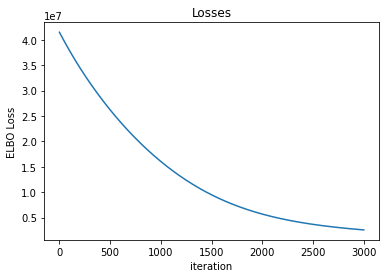

In [14]:
# Plot the loses
pseudo_time_reg_deconv.plot_loss()

In [15]:
pyro.get_param_store().keys()

dict_keys(['log_phi_posterior_loc_g', 'log_beta_posterior_loc_g', 'gp.f_loc', 'gp.f_scale_tril', 'f_posterior_loc_mc', 'gp.kernel.kern0.lengthscale', 'gp.kernel.kern0.variance', 'gp.kernel.kern1.variance', 'gp_f_mean_c'])

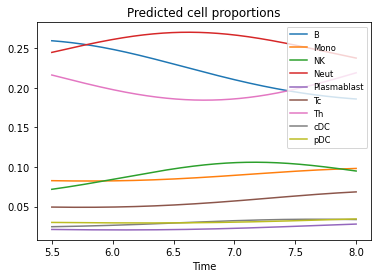

In [16]:
pseudo_time_reg_deconv.plot_composition_trajectories()

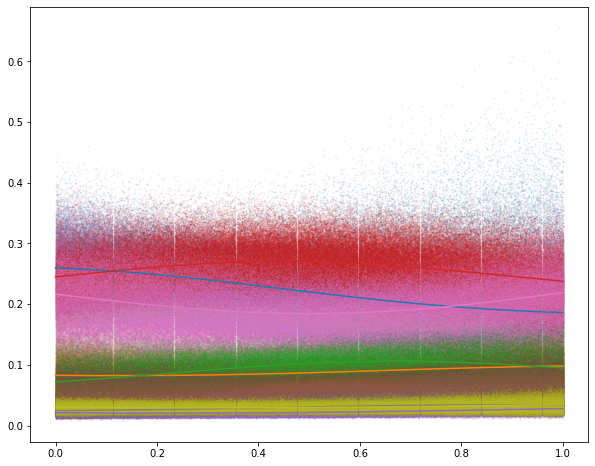

In [17]:
pseudo_time_reg_deconv.plot_composition_trajectories(show_sampled_trajectories = True, n_samples=500)

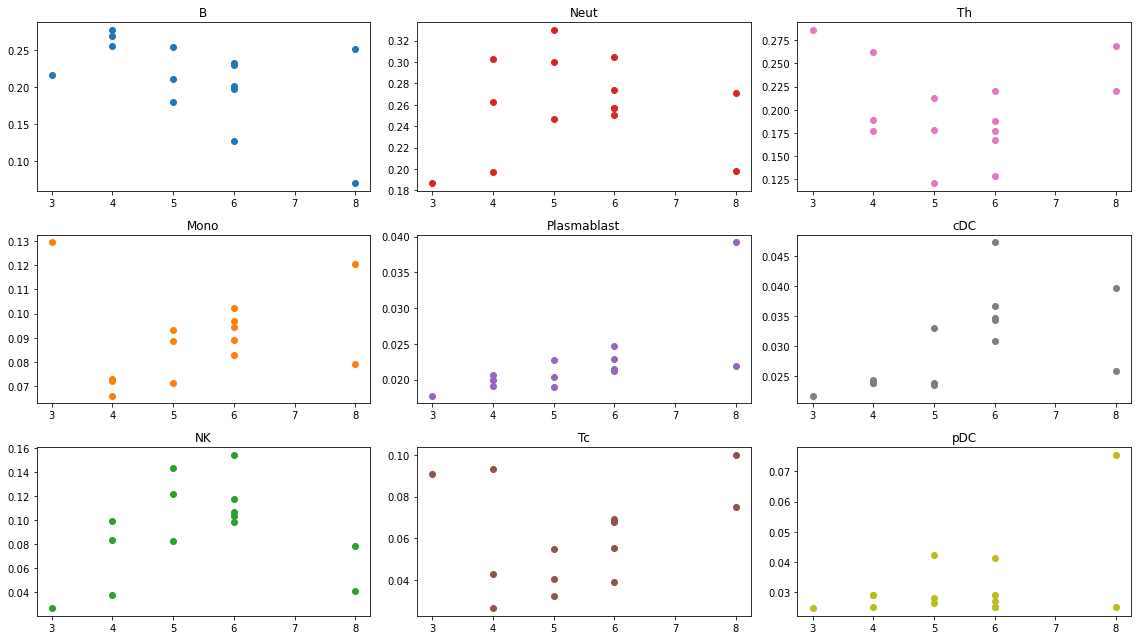

In [18]:
pseudo_time_reg_deconv.plot_sample_compositions_scatter()

In [19]:
# Do correlation between different cell types

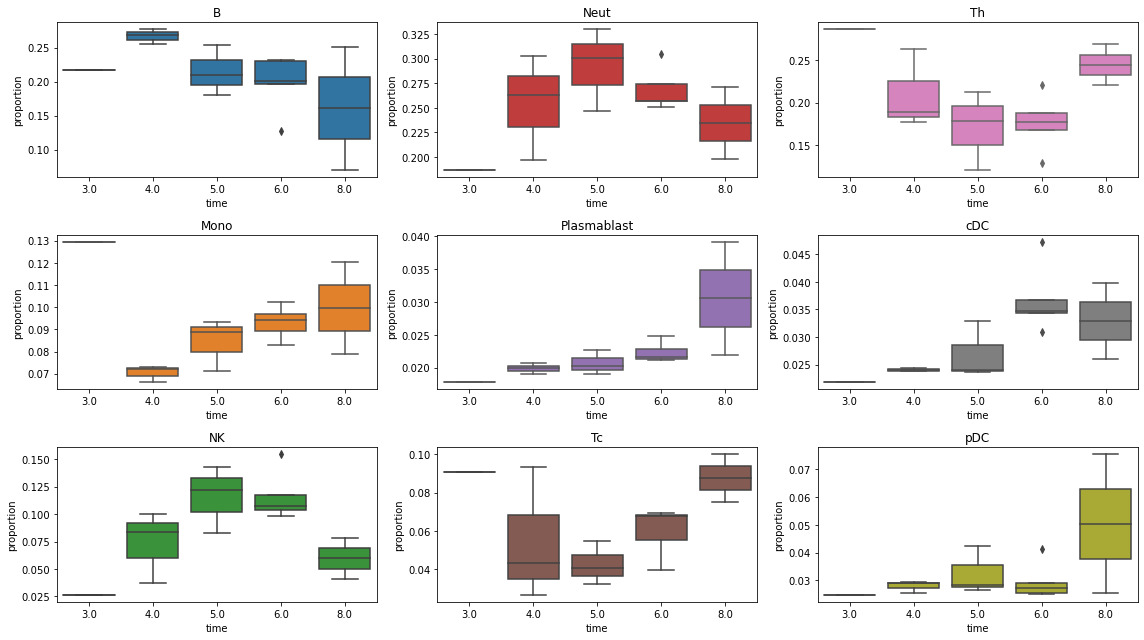

In [20]:
pseudo_time_reg_deconv.plot_sample_compositions_boxplot()
matplotlib.pyplot.show()